##### Definicion de lenet5 by Dive into deep learning
https://d2l.ai/chapter_convolutional-neural-networks/lenet.html

### Recursos tenidos en cuenta para implementar el modelo
(contiene implementacion del modelo)

https://d2l.ai/chapter_linear-classification/classification.html

(contiene implementacion del modelo)

https://blog.paperspace.com/writing-lenet5-from-scratch-in-python/ 

##### Tutorial oficial pytorch
https://pytorch.org/tutorials/beginner/basics/intro.html 

Clase Sequential

https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html?highlight=sequential#torch.nn.Sequential

Capa Conv2d 

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html




In [2]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
from numpy import pad
import torch
from torch import nn
class Lenet5(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # se reciben imagenes 3x32x32
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0), # quedan un volumen de 6x28x28 # (n - k + s + p)/s
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2) # queda un volumen de 6x14x14
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0), # queda un volumen de 16x10x10
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # queda un volumen de 16x5x5 = 400.
        )

        self.denseLayer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=400, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10)
        )
    
    def forward(self, x):
        logits = self.layer1(x)
        logits = self.layer2(logits)
        logits = self.denseLayer(logits)
        # no es necesario utilizar softmax, ya que el optimizador lo integra, pero es necesario agregarlo por afuera para cuando se utilice el modo de evaluacion.
        return logits


In [4]:
random = torch.rand(1,3,32,32)
model = Lenet5()
model.eval()
print(model(random))

tensor([[ 0.0091, -0.0369, -0.0919,  0.0281,  0.0243,  0.0268, -0.0336, -0.0486,
          0.0407,  0.0938]], grad_fn=<AddmmBackward0>)


In [5]:
"""
Definir funcion de costo y optimizador

Explicacion sobre la optimizacion 

https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

"""
import torch
from torch import nn
# CrossEntropyLoss requiere el output "logits", no es necesario pasarlo por el softmax, ya que lo calcula dentro. https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
loss_function = nn.CrossEntropyLoss()
# se necesita enviar los parametros del modelo al optimizador para que los pueda actualizar.
optimizer = torch.optim.Adam(model.parameters())



In [6]:
"""
Entramiento
"""

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Files already downloaded and verified
Files already downloaded and verified


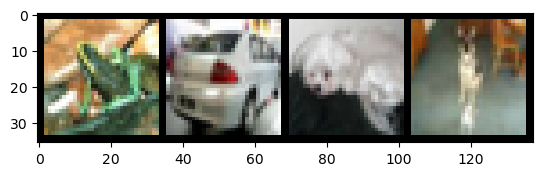

frog  car   dog   dog  
torch.Size([3, 32, 32])
max value tensor(1.)
min value tensor(0.0471)
tensor([[[0.9333, 0.8863, 0.9647,  ..., 0.2824, 0.3333, 0.5725],
         [0.8863, 0.9098, 0.9137,  ..., 0.4667, 0.8471, 0.9098],
         [0.8431, 0.8667, 0.8784,  ..., 0.9608, 1.0000, 0.9882],
         ...,
         [0.4353, 0.3922, 0.3569,  ..., 0.4941, 0.4824, 0.3961],
         [0.5647, 0.4196, 0.3490,  ..., 0.5608, 0.7137, 0.5725],
         [0.5569, 0.3529, 0.3922,  ..., 0.5569, 0.7882, 0.6745]],

        [[0.8627, 0.8235, 0.9020,  ..., 0.2118, 0.2706, 0.4431],
         [0.8235, 0.8392, 0.8353,  ..., 0.4588, 0.7529, 0.7451],
         [0.7569, 0.7529, 0.7608,  ..., 0.9608, 0.9608, 0.8471],
         ...,
         [0.3765, 0.3765, 0.3451,  ..., 0.5216, 0.5059, 0.4863],
         [0.4471, 0.3765, 0.3412,  ..., 0.5333, 0.6039, 0.5725],
         [0.4745, 0.3569, 0.4275,  ..., 0.5059, 0.6549, 0.6627]],

        [[0.7137, 0.6745, 0.7216,  ..., 0.1059, 0.1882, 0.3176],
         [0.6863, 0.6941, 0.6

KeyboardInterrupt: 

In [8]:
%run cargar_datos.ipynb

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(trainloader, model, loss_function, optimizer)
    test_loop(testloader, model, loss_function)
print("Done!")